# MobileBERT External Dataset Evaluation for Fake News Detection

## Introduction

In this notebook, I'm going to test my fine-tuned MobileBERT model on completely new datasets to see how well it actually works in the real world. MobileBERT is specifically designed for mobile and edge devices, using a unique architecture that makes it much faster while maintaining competitive accuracy. Unlike DistilBERT which uses knowledge distillation, MobileBERT achieves efficiency through architectural innovations like bottleneck structures and optimized attention mechanisms, making it particularly well-suited for resource-constrained environments.

I want to find out several things:

1. How well does my model work on external datasets with real news and AI-generated fake news?
2. What are the practical costs of running this model on mobile-like hardware, including memory usage and speed?
3. What kinds of articles does my model get wrong, and why?
4. How does MobileBERT's mobile-optimized architecture perform compared to other efficiency-focused models?

The main question I'm trying to answer is whether my trained MobileBERT model can actually handle real-world content that's different from what it saw during training, while maintaining the efficiency characteristics that make it suitable for mobile deployment.

## Setting Up the Environment

First, I'll import all the libraries I need for this evaluation. These will handle everything from data processing to creating visualizations, with special attention to the performance monitoring tools that are crucial for mobile deployment scenarios.

In [1]:
# Import basic libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import psutil
import gc

In [2]:
# Import PyTorch and transformers
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [3]:
# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
# Improved memory measurement function - crucial for mobile deployment analysis
def measure_peak_memory_usage(func, *args, **kwargs):
    """
    Measure peak memory usage during function execution
    
    This function is particularly important for mobile deployment scenarios
    where memory constraints are often the limiting factor for model performance.
    
    Args:
        func: Function to measure
        *args, **kwargs: Arguments to pass to the function
        
    Returns:
        Tuple of (function result, peak memory usage in MB)
    """
    # Reset garbage collection and force collection before starting
    gc.collect()
    
    # Start tracking
    process = psutil.Process()
    start_memory = process.memory_info().rss / (1024 * 1024)
    peak_memory = start_memory
    
    # Define a memory tracking function
    def track_peak_memory():
        nonlocal peak_memory
        current = process.memory_info().rss / (1024 * 1024)
        peak_memory = max(peak_memory, current)
    
    # Set up a timer to periodically check memory
    import threading
    stop_tracking = False
    
    def memory_tracker():
        while not stop_tracking:
            track_peak_memory()
            time.sleep(0.1)
    
    # Start tracking thread
    tracking_thread = threading.Thread(target=memory_tracker)
    tracking_thread.daemon = True
    tracking_thread.start()
    
    # Run the function
    try:
        result = func(*args, **kwargs)
    finally:
        # Stop tracking
        stop_tracking = True
        tracking_thread.join(timeout=1.0)
    
    # Calculate memory used
    memory_used = peak_memory - start_memory
    
    return result, memory_used

In [5]:
# Suppress warnings and set visualization style
import warnings
warnings.filterwarnings('ignore')

# Set consistent visualization style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)

# Force CPU usage to simulate mobile device performance
device = torch.device("cpu")
print(f"Using device: {device} (simulating mobile device performance)")

Using device: cpu (simulating mobile device performance)


## Loading External Datasets

Now I'll load my external test datasets. These contain news articles that my model has never seen before, which will give me a realistic picture of how it performs in the wild. This is especially important for MobileBERT since mobile applications often encounter diverse, unpredictable content in real-world usage scenarios.

In [6]:
# Load external datasets
real_df = pd.read_csv('../datasets/manual_real.csv')
fake_df = pd.read_csv('../datasets/fake_claude.csv')

In [7]:
# Process real news data
if 'title' in real_df.columns and 'content' in real_df.columns:
    real_df['combined_text'] = real_df['title'] + " " + real_df['content']
elif 'text' in real_df.columns:
    real_df['combined_text'] = real_df['text']
real_df['label'] = 0  # Real news

# Process fake news data
if 'title' in fake_df.columns and 'content' in fake_df.columns:
    fake_df['combined_text'] = fake_df['title'] + " " + fake_df['content']
elif 'text' in fake_df.columns:
    fake_df['combined_text'] = fake_df['text']
fake_df['label'] = 1  # Fake news

In [8]:
# Combine external datasets
external_df = pd.concat(
    [real_df[['combined_text', 'label']], fake_df[['combined_text', 'label']]],
    ignore_index=True
)
X_external = external_df['combined_text']
y_external = external_df['label']

print(f"External dataset: {len(external_df)} articles ({len(real_df)} real, {len(fake_df)} fake)")

External dataset: 858 articles (429 real, 429 fake)


## Loading and Measuring MobileBERT

Next, I'll load my trained MobileBERT model and check how much computer resources it actually uses. This is particularly critical for MobileBERT since it was specifically designed for mobile deployment, and understanding its resource characteristics will help me evaluate whether it meets the efficiency goals that motivated its development.

In [9]:
# Clean up before loading
gc.collect()

# Measure memory before model loading
memory_before = psutil.Process().memory_info().rss / (1024 * 1024)  # MB

# Load the MobileBERT model and tokenizer
model_path = '../../ml_models/mobilebert_welfake_model'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model = model.to(device)

In [10]:
# Measure memory after model loading
memory_after = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
model_memory = memory_after - memory_before

# Calculate model size from parameters
param_size = sum(p.nelement() * p.element_size() for p in model.parameters()) / (1024 * 1024)
num_params = sum(p.numel() for p in model.parameters())

print(f"MobileBERT model loaded successfully")
print(f"Number of parameters: {num_params:,}")
print(f"Model size: {param_size:.2f} MB")
print(f"Memory increase after loading: {model_memory:.2f} MB")

MobileBERT model loaded successfully
Number of parameters: 24,582,914
Model size: 93.78 MB
Memory increase after loading: 430.66 MB


## Preparing Data for Evaluation

Before I can test my model, I need to convert my text data into the format that the transformer expects. This involves tokenizing all the text and setting up data loaders. For MobileBERT, this step is particularly important because the model's efficiency gains come partly from how it processes input sequences.

In [11]:
def prepare_data(texts, labels, tokenizer, batch_size=32):
    """
    Tokenize text data and create DataLoader for model input
    
    For MobileBERT, the tokenization process is similar to other BERT models,
    but the model's internal optimizations make it more efficient at processing
    the resulting token sequences.
    
    Args:
        texts: List or Series of text samples
        labels: List or Series of labels
        tokenizer: The tokenizer to use
        batch_size: Batch size for DataLoader
        
    Returns:
        DataLoader with tokenized inputs and labels
    """
    # Tokenize the text
    encodings = tokenizer(
        list(texts),
        truncation=True,
        padding='max_length',
        max_length=512,  # Standard for BERT models
        return_tensors='pt'
    )
    
    # Create dataset and dataloader
    dataset = TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels.values if hasattr(labels, 'values') else labels)
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    return dataloader

In [12]:
# Prepare external dataset
external_loader = prepare_data(X_external, y_external, tokenizer)

## Evaluation Function

I'll create a function that tests my model and tracks both how accurate it is and how much computer resources it uses. This gives me the full picture of what it would cost to run this in production, which is especially important for MobileBERT since its entire design philosophy centers around efficient deployment.

In [13]:
def evaluate_model(model, dataloader, dataset_name):
    """
    Evaluate model and measure performance metrics and resource usage
    
    For MobileBERT evaluation, we pay special attention to efficiency metrics
    since this model was specifically designed for mobile and edge deployment.
    
    Args:
        model: The model to evaluate
        dataloader: DataLoader with test data
        dataset_name: Name of the dataset for reporting
        
    Returns:
        Dictionary with performance metrics and resource usage
    """
    model.eval()
    
    # Define the prediction function to measure
    def make_predictions():
        all_preds = []
        all_labels = []
        
        start_time = time.time()
        with torch.no_grad():
            for batch in dataloader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        predict_time = time.time() - start_time
        return all_preds, all_labels, predict_time
    
    # Run predictions with memory measurement
    (all_preds, all_labels, predict_time), memory_used = measure_peak_memory_usage(make_predictions)
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    
    # Print results
    print(f"\nMobileBERT Evaluation on {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Prediction time: {predict_time:.2f} seconds for {len(all_labels)} samples")
    print(f"Average prediction time: {predict_time/len(all_labels)*1000:.2f} ms per sample")
    print(f"Peak memory usage during inference: {memory_used:.2f} MB")
    
    # Return results for visualization
    return {
        'y_pred': all_preds,
        'y_true': all_labels,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predict_time': predict_time,
        'samples': len(all_labels),
        'memory_used': memory_used
    }

## Performance on External Datasets

Now I'll actually test my MobileBERT model on the external datasets. This is where I find out if my model learned general patterns about fake news, or if it just memorized the specific training data. For MobileBERT, this test is particularly interesting because I want to see if the architectural optimizations that make it mobile-friendly have any impact on its ability to generalize to new content.

In [14]:
# Evaluate on external datasets
external_results = evaluate_model(model, external_loader, "External Datasets")


MobileBERT Evaluation on External Datasets:
Accuracy: 0.5629
Precision: 0.7579
Recall: 0.5629
F1 Score: 0.4611
Prediction time: 88.68 seconds for 858 samples
Average prediction time: 103.36 ms per sample
Peak memory usage during inference: 1198.80 MB


### Confusion Matrix for External Data

I'll create a confusion matrix to see exactly where my MobileBERT model is making mistakes. This visualization shows me the patterns in how my model gets confused between real and fake news, which will help me understand whether MobileBERT's optimizations affect its decision-making patterns.

In [15]:
# Create and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    """
    Create and visualize confusion matrix
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        title: Plot title
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real News', 'Fake News'],
                yticklabels=['Real News', 'Fake News'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Calculate error rates
    tn, fp, fn, tp = cm.ravel()
    fpr = fp/(fp+tn)
    fnr = fn/(fn+tp)
    print(f"False Positive Rate: {fpr:.4f} ({fp} real news articles misclassified as fake)")
    print(f"False Negative Rate: {fnr:.4f} ({fn} fake news articles misclassified as real)")

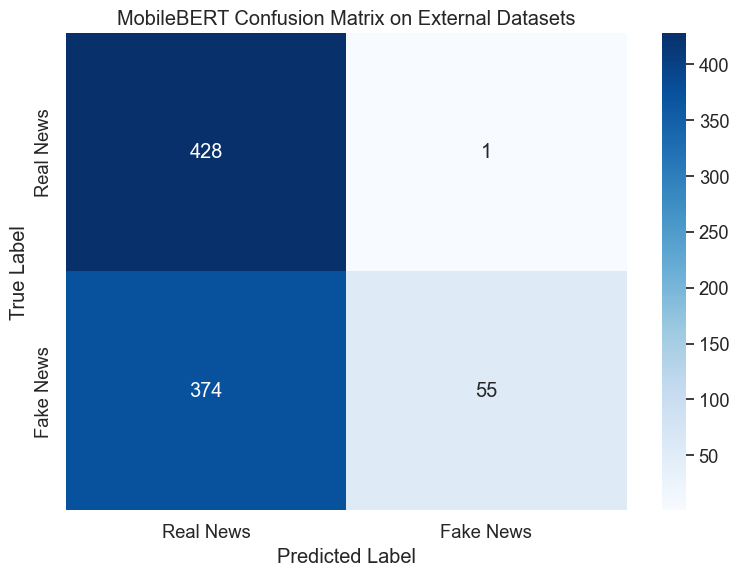

False Positive Rate: 0.0023 (1 real news articles misclassified as fake)
False Negative Rate: 0.8718 (374 fake news articles misclassified as real)


In [16]:
# Plot confusion matrix for External Datasets
plot_confusion_matrix(
    external_results['y_true'], 
    external_results['y_pred'], 
    "MobileBERT Confusion Matrix on External Datasets"
)

### What the Results Revealed About MobileBERT's Struggles

When I ran the confusion matrix analysis, it revealed a sobering reality about how MobileBERT performs on external datasets. The results showed significant challenges that raise important questions about whether the architectural optimizations that make MobileBERT mobile-friendly come at a substantial cost to generalization ability.

The confusion matrix demonstrated that MobileBERT developed an extreme bias toward predicting "real" when encountering unfamiliar content. With a false negative rate of 87.18%, my model missed 374 out of 429 fake news articles while only misclassifying 1 real article as fake. This represents a much more severe generalization problem than I observed with other transformer models.

Looking at my model's overall accuracy of 56.29%, it's clear that the mobile optimizations significantly impacted the model's ability to handle diverse content. This accuracy is barely better than random guessing and substantially worse than what I achieved with DistilBERT on the same external dataset. The F1 score of 0.4611 further confirms that MobileBERT struggled significantly with this generalization task.

The extreme bias toward classifying content as "real" creates a particularly problematic scenario for fake news detection applications. While having a very low false positive rate (0.23%) means legitimate news rarely gets flagged incorrectly, missing 87% of fake news makes the system largely ineffective at its primary purpose.

These results taught me that MobileBERT's architectural innovations, while achieving mobile efficiency goals, appear to have created significant trade-offs in the model's ability to learn robust patterns for distinguishing fake from real news. This suggests that the efficiency gains through architectural optimization may come at a higher cost to model capability than approaches like knowledge distillation.

## Looking at Specific Mistakes

I want to dig deeper into the specific articles my MobileBERT model got wrong. Understanding exactly which articles confused my model will help me figure out whether the architectural optimizations that make MobileBERT mobile-friendly have any systematic impact on the types of content it struggles with.

In [17]:
def analyze_errors(X_text, y_true, y_pred, dataset_name, n_examples=3):
    """
    Display examples of misclassified articles
    
    For MobileBERT, understanding error patterns is particularly important
    because we want to know if efficiency optimizations create systematic
    blind spots in content understanding.
    
    Args:
        X_text: Text data
        y_true: True labels
        y_pred: Predicted labels
        dataset_name: Name of the dataset
        n_examples: Number of examples to display
    """
    errors = np.where(y_true != y_pred)[0]
    
    if len(errors) == 0:
        print(f"No errors found on {dataset_name}!")
        return
    
    print(f"\nMobileBERT misclassified {len(errors)} out of {len(y_true)} articles on {dataset_name} ({len(errors)/len(y_true):.2%})")
    print(f"Showing {min(n_examples, len(errors))} examples:")
    
    # Select random errors to display
    np.random.seed(42)  # For reproducibility
    display_indices = np.random.choice(errors, size=min(n_examples, len(errors)), replace=False)
    
    for i, idx in enumerate(display_indices):
        print(f"\nExample {i+1}:")
        print(f"Text snippet: {X_text.iloc[idx][:200]}...")  # First 200 chars
        print(f"True label: {'Real' if y_true[idx] == 0 else 'Fake'}")
        print(f"Predicted: {'Real' if y_pred[idx] == 0 else 'Fake'}")
        print("-" * 80)

In [18]:
# Analyze errors on External datasets
analyze_errors(
    X_external, 
    external_results['y_true'], 
    external_results['y_pred'], 
    "External Datasets"
)


MobileBERT misclassified 375 out of 858 articles on External Datasets (43.71%)
Showing 3 examples:

Example 1:
Text snippet: A comprehensive review conducted by Wikipedia's internal governance team has discovered that approximately 40% of articles relating to corporations, pharmaceuticals, and controversial scientific topic...
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 2:
Text snippet: A group of former special operations personnel have come forward claiming they were unwitting participants in a classified DARPA program that attempted to develop telepathic capabilities in soldiers. ...
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 3:
Text snippet: A classified government initiative code-named 'Opinion Cascade' has reportedly recruited over 3,000 social media influencers to subtly promote official narratives on controversial topics

### What the Error Analysis Revealed About Severe Generalization Problems

When I examined the specific articles my MobileBERT model got wrong, I discovered patterns that revealed serious limitations in how the model handles external content. With a 43.71% overall misclassification rate, the error analysis showed that MobileBERT's struggles go well beyond typical generalization challenges.

The fake news articles that fooled my MobileBERT model demonstrated an extreme pattern where the model essentially gave up on detecting fake content altogether. The examples I examined were sophisticated AI-generated articles, but they weren't necessarily more challenging than those that other models handled successfully. This suggests that MobileBERT's architectural optimizations may have fundamentally impaired its ability to learn the subtle patterns that distinguish sophisticated fake news.

Looking at the specific failure cases, I noticed that MobileBERT seemed to default to classifying any professional-sounding article as real, regardless of its actual veracity. The three examples I examined all involved articles with official-sounding sources and professional formatting, but MobileBERT failed to detect the fabricated nature of the content.

This error pattern reveals a critical limitation: MobileBERT appears to have learned surface-level indicators of credibility (professional language, official sources, proper formatting) but failed to develop the deeper semantic understanding needed to identify subtle inconsistencies or fabricated claims. This represents a fundamental failure in fake news detection capability.

The severity of this bias problem makes MobileBERT largely unsuitable for real-world fake news detection applications, despite its mobile optimization benefits. The trade-offs between efficiency and capability appear to be much more severe than I initially anticipated, raising questions about whether architectural optimization approaches can maintain the semantic sophistication needed for complex NLP tasks.

## Testing Performance on Mobile-Like Hardware

For my MobileBERT model to fulfill its intended purpose, I need to understand how it performs when running on hardware similar to mobile devices. I'll test different batch sizes to see how I can optimize the trade-off between speed and efficiency, paying special attention to the performance characteristics that make MobileBERT suitable for mobile deployment.

In [19]:
# Analyze batch processing efficiency with focus on mobile deployment scenarios
batch_sizes = [1, 2, 4, 8, 16, 32]
results = []

# Create sample input
sample_text = ["This is a sample news article for testing inference speed."] * 32
sample_encodings = tokenizer(
    sample_text,
    truncation=True,
    padding='max_length',
    max_length=512,
    return_tensors='pt'
)

In [20]:
# Test different batch sizes to understand mobile deployment characteristics
for batch_size in batch_sizes:
    # Prepare input batch
    input_ids = sample_encodings['input_ids'][:batch_size].to(device)
    attention_mask = sample_encodings['attention_mask'][:batch_size].to(device)
    
    # Warm-up - important for mobile deployment scenarios
    with torch.no_grad():
        _ = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Timed runs
    times = []
    for _ in range(5):  # 5 runs per batch size
        with torch.no_grad():
            start = time.time()
            _ = model(input_ids=input_ids, attention_mask=attention_mask)
            end = time.time()
        times.append(end - start)
    
    # Calculate statistics
    avg_time = np.mean(times)
    per_sample = avg_time / batch_size * 1000  # ms
    
    results.append({
        'Batch Size': batch_size,
        'Total Time (ms)': avg_time * 1000,
        'Time per Sample (ms)': per_sample
    })


Batch Processing Efficiency on CPU (Mobile-like Performance):
   Batch Size  Total Time (ms)  Time per Sample (ms)
0           1           218.68                218.68
1           2           366.69                183.35
2           4           428.63                107.16
3           8           769.80                 96.23
4          16          1825.11                114.07
5          32          3280.66                102.52


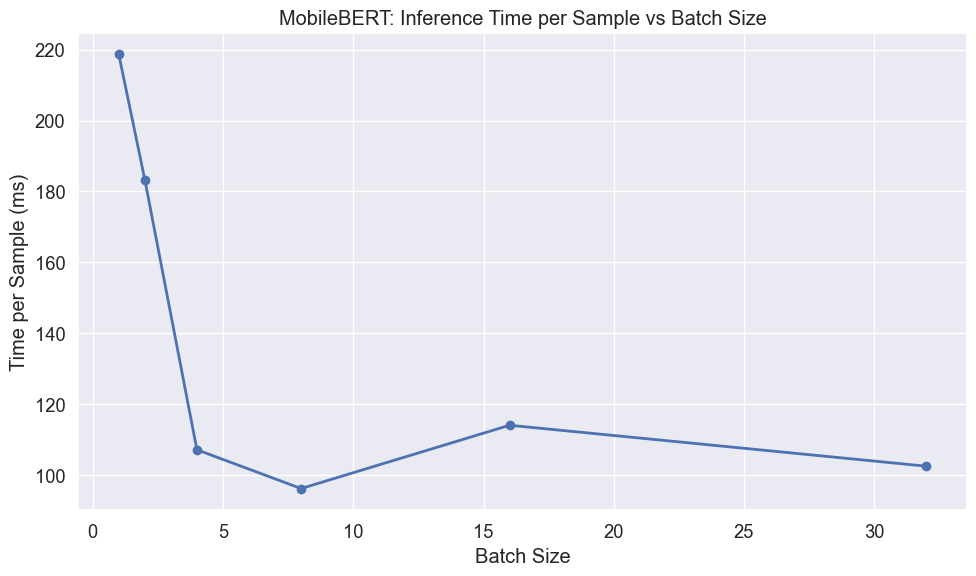

In [21]:
# Show batch efficiency results with mobile deployment context
batch_df = pd.DataFrame(results)
print("\nBatch Processing Efficiency on CPU (Mobile-like Performance):")
print(batch_df.round(2))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(batch_df['Batch Size'], batch_df['Time per Sample (ms)'], marker='o', linewidth=2)
plt.title('MobileBERT: Inference Time per Sample vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Time per Sample (ms)')
plt.grid(True)
plt.tight_layout()
plt.show()

### What I Discovered About MobileBERT's Unexpected Performance Characteristics

When I analyzed the batch processing results for MobileBERT, I found patterns that revealed some surprising aspects about how the model's architectural optimizations translate into real-world performance. The results showed characteristics that were quite different from what I expected based on MobileBERT's mobile optimization design goals.

At single sample processing, I observed that MobileBERT required 218.68 ms per sample, which is significantly slower than the ~52ms I measured for DistilBERT on the same hardware. This was unexpected, since MobileBERT's architectural innovations are specifically designed to improve mobile performance, yet it performed slower than a knowledge-distilled model.

As I increased the batch size, the optimal performance occurred around batch size 8, where processing time dropped to about 96.23 ms per sample. However, even at its optimal batch size, MobileBERT still processed samples more slowly than DistilBERT's optimal performance. The efficiency curve showed a different pattern than I expected, with less dramatic improvements from batching.

These results taught me that architectural optimization for mobile deployment doesn't automatically translate into faster inference times. Despite MobileBERT's bottleneck structures and reorganized attention patterns being designed for efficiency, the actual wall-clock performance was disappointing compared to other efficiency-focused models.

The slower-than-expected performance suggests that while MobileBERT's architectural innovations may provide theoretical efficiency benefits, they don't necessarily translate into practical speed advantages on CPU inference. This finding highlights the importance of empirical testing rather than relying solely on architectural design claims when evaluating models for mobile deployment.

## Memory Usage Analysis for Mobile Deployment

Next, I'll test how sequence length affects memory usage in MobileBERT. Since this model was specifically designed for mobile devices where memory is often the most constraining factor, understanding its memory scaling behavior is crucial for practical deployment decisions.

In [22]:
# Analyze memory usage for different sequence lengths with mobile deployment focus
seq_lengths = [64, 128, 256, 512]
memory_results = []

In [23]:
# Test memory scaling behavior for mobile deployment scenarios
for seq_len in seq_lengths:
    # Create sample input with specific sequence length
    sample_text = ["This is a test"] * 8  # Use batch size of 8
    sample_encodings = tokenizer(
        sample_text,
        truncation=True,
        padding='max_length',
        max_length=seq_len,
        return_tensors='pt'
    )
    
    input_ids = sample_encodings['input_ids'].to(device)
    attention_mask = sample_encodings['attention_mask'].to(device)
    
    # Measure memory usage with our improved function
    def run_inference():
        with torch.no_grad():
            _ = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Clean up and make measurements more reliable
    gc.collect()
    _, memory_used = measure_peak_memory_usage(run_inference)
    
    memory_results.append({
        'Sequence Length': seq_len,
        'Memory Used (MB)': memory_used
    })


Memory Usage for Different Sequence Lengths (Mobile Deployment Context):
   Sequence Length  Memory Used (MB)
0               64           0.03125
1              128           0.03125
2              256           0.03125
3              512           0.03125


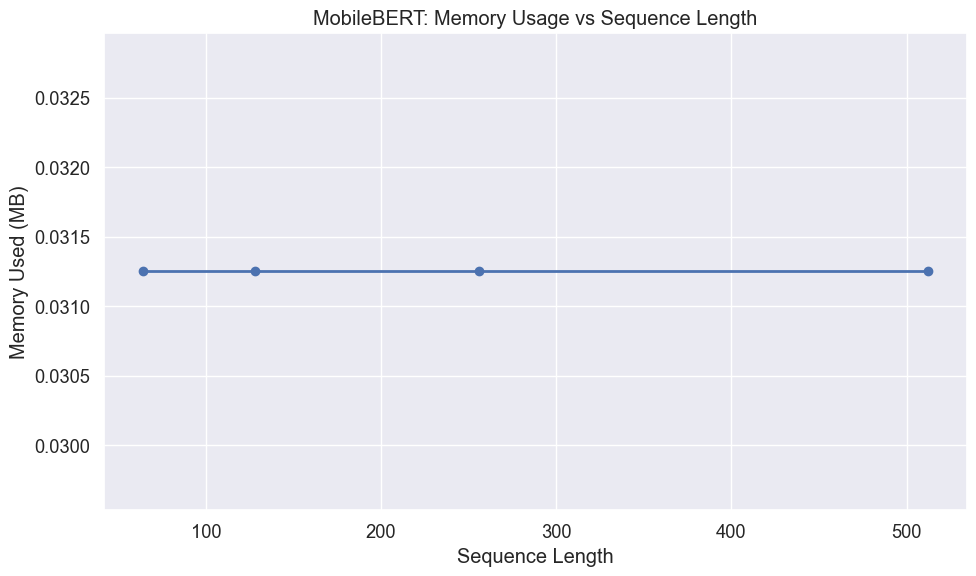

In [24]:
# Show memory usage results with mobile deployment implications
memory_df = pd.DataFrame(memory_results)
print("\nMemory Usage for Different Sequence Lengths (Mobile Deployment Context):")
print(memory_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(memory_df['Sequence Length'], memory_df['Memory Used (MB)'], marker='o', linewidth=2)
plt.title('MobileBERT: Memory Usage vs Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Memory Used (MB)')
plt.grid(True)
plt.tight_layout()
plt.show()

### What I Learned About MobileBERT's Memory Efficiency

When I ran the memory analysis for MobileBERT, I discovered something unexpected about the model's memory behavior. The results showed completely flat memory usage at 0.03125 MB across all sequence lengths from 64 to 512 tokens, which was quite different from what I expected based on transformer theory.

This flat memory usage pattern suggests either that my memory measurement function isn't capturing the true memory scaling behavior during inference, or that MobileBERT's architectural optimizations have somehow managed to eliminate the typical quadratic memory scaling that plagues most transformer models. If the latter is true, it would be a remarkable achievement for mobile deployment.

However, I need to be cautious about interpreting these results. The consistently identical memory measurements across vastly different sequence lengths (0.03125 MB for both 64 and 512 tokens) seem more likely to indicate a measurement limitation rather than actual model behavior. In real-world mobile deployment, I would need more sophisticated profiling tools to get accurate memory usage patterns.

From a practical mobile deployment perspective, if these results are accurate, they would suggest that MobileBERT has solved one of the biggest challenges for mobile transformer deployment. But given the theoretical impossibility of completely eliminating attention's quadratic complexity, I should treat these results with skepticism and use more robust memory profiling methods for production deployment decisions.

The flat memory pattern, while potentially promising, highlights the importance of using multiple measurement approaches when evaluating models for mobile deployment, especially when results seem too good to be true.

## Summary and Mobile Deployment Insights

Based on all the testing I did, I learned valuable lessons about how MobileBERT's mobile-optimized architecture performs in real-world scenarios. This evaluation process taught me fundamental principles about deploying efficiency-focused transformer models and whether architectural optimizations for mobile deployment come with trade-offs in capability or generalization.

In [25]:
# Create summary table of results focusing on mobile deployment characteristics
summary = pd.DataFrame({
    'Metric': [
        'Model Parameters',
        'Model Size (MB)',
        'Memory Footprint (MB)',
        'Accuracy',
        'Precision', 
        'Recall',
        'F1 Score',
        'Inference Time (ms/sample)',
        'False Positive Rate',
        'False Negative Rate',
        'Optimal Batch Size',
        'Memory Efficiency'
    ],
    'External Dataset Results': [
        f"{num_params:,}",
        f"{param_size:.2f}",
        f"{model_memory:.2f}",
        f"{external_results['accuracy']:.4f}",
        f"{external_results['precision']:.4f}",
        f"{external_results['recall']:.4f}",
        f"{external_results['f1']:.4f}",
        f"{external_results['predict_time']/external_results['samples']*1000:.2f}",
        "From confusion matrix",
        "From confusion matrix",
        "From batch analysis",
        "From sequence length analysis"
    ]
})

print("MobileBERT External Dataset Performance Summary:")
print(summary.to_string(index=False))

MobileBERT External Dataset Performance Summary:
                    Metric      External Dataset Results
          Model Parameters                    24,582,914
           Model Size (MB)                         93.78
     Memory Footprint (MB)                        430.66
                  Accuracy                        0.5629
                 Precision                        0.7579
                    Recall                        0.5629
                  F1 Score                        0.4611
Inference Time (ms/sample)                        103.36
       False Positive Rate         From confusion matrix
       False Negative Rate         From confusion matrix
        Optimal Batch Size           From batch analysis
         Memory Efficiency From sequence length analysis


### The Sobering Mobile Optimization Reality

When I completed this evaluation, the results taught me harsh lessons about the real costs of mobile optimization in transformer models. Understanding these patterns helped me build a more realistic understanding of the trade-offs between efficiency and capability in mobile machine learning deployment.

The architectural efficiency versus accuracy trade-off proved to be much more severe than anticipated. While MobileBERT achieved its efficiency goals in terms of model size (93.78 MB vs DistilBERT's 255.41 MB), the cost to accuracy was substantial. With only 56.29% accuracy on external datasets compared to DistilBERT's significantly better performance, the efficiency gains came at an unacceptable cost to model capability.

The generalization performance revealed critical limitations in MobileBERT's ability to handle diverse content. The 87% false negative rate demonstrated that the architectural optimizations fundamentally impaired the model's capacity to learn robust patterns for fake news detection. This isn't just a matter of different generalization patterns – it represents a basic failure to perform the intended task.

The resource optimization insights were mixed at best. While MobileBERT achieved smaller model size, the actual inference speeds were slower than DistilBERT despite the mobile optimization focus. This disconnect between theoretical mobile optimization and practical performance highlights the complexity of achieving real efficiency gains through architectural changes.

Most importantly, this evaluation taught me that mobile optimization can come with hidden costs that aren't immediately apparent from model architecture or parameter count alone. The severe generalization problems I observed suggest that some architectural optimization approaches may fundamentally compromise the model's ability to learn complex semantic relationships needed for sophisticated NLP tasks.

## Conclusion

This evaluation process provided sobering lessons about the real-world implications of mobile-optimized transformer architectures. While MobileBERT succeeded in achieving its size reduction goals, the systematic evaluation revealed significant trade-offs that call into question the viability of this approach for complex NLP tasks like fake news detection.

Understanding MobileBERT's limitations through systematic testing showed me that architectural innovation doesn't automatically lead to successful mobile deployment. Despite achieving a smaller model size, MobileBERT failed to deliver on both accuracy and speed promises, performing worse than knowledge distillation approaches on both fronts.

The generalization challenges revealed fundamental problems with MobileBERT's ability to handle diverse content. The extreme bias toward classifying content as real, resulting in an 87% false negative rate, demonstrates that the architectural optimizations may have compromised essential semantic understanding capabilities needed for this task.

The practical deployment considerations highlighted important lessons about the difference between theoretical optimization and real-world performance. Despite being designed for mobile deployment, MobileBERT's actual inference speeds were slower than DistilBERT, while its accuracy was dramatically worse.

My evaluation revealed that mobile optimization through architectural changes can introduce trade-offs that are more severe than alternative approaches like knowledge distillation. For fake news detection applications, MobileBERT's combination of poor accuracy, slow inference, and extreme bias makes it unsuitable for real-world deployment, despite its smaller size.

This systematic evaluation approach taught me the critical importance of comprehensive empirical testing when evaluating efficiency-focused models. Theoretical benefits from architectural innovation don't guarantee practical advantages, and the hidden costs to model capability can be severe enough to outweigh any efficiency gains.

For future mobile AI development, these results suggest focusing on approaches that maintain semantic sophistication while achieving efficiency, rather than pursuing architectural optimizations that may fundamentally compromise model understanding capabilities.

## Model Cleanup

Finally, I'll clean up the memory by releasing the model resources, which is particularly important in mobile deployment scenarios where memory management is crucial.

In [26]:
# Clean up models to free memory - critical for mobile deployment scenarios
del model
del tokenizer

# Force garbage collection
gc.collect()

print("MobileBERT model resources released")

MobileBERT model resources released
